In [ ]:

cheapest_history: list[tuple[list[int],list[tuple[int,int,list[int]]],int]] = []
from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve    
from tsp.experiment.batch_solver import solve_batch
from tsp.experiment.batch import save_problem_batch
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import json

cities = TSP.generate_random(50, w=500, h=500)
save_problem_batch([cities], 'pyramid_test/problems')

def pyramid_solve_2_4(problem):
    return pyramid_solve(problem, k=3, s=2)
solve_batch('pyramid_test/problems', pyramid_solve_2_4, 'pyramid_test/pyr_solutions')

def load_tsp_coords(fp):
    with open(fp,'r') as f:
        return np.array(json.load(f)["cities"])

coords = load_tsp_coords("pyramid_test/problems/001.tsp")
num_cities = coords.shape[0]
print("Coords shape:", coords.shape)

tsp_problem = TSP.from_cities(coords, w=500, h=500)
centroids = [ np.array(pt, dtype=float) for pt in coords ]
nodes     = list(range(len(coords)))

def tour_length(tour: list[int]) -> float:
    idxs   = tour + [tour[0]]
    pts    = coords[idxs]
    deltas = pts[1:] - pts[:-1]
    return np.hypot(deltas[:,0], deltas[:,1]).sum()

history = []  

def _cheapest_insertion_recorded(centroids: list[np.ndarray], nodes: list[int], prev_centroid: np.ndarray|None, next_centroid: np.ndarray|None) -> list[int]:
    tour = [nodes[0], nodes[1]]
    while len(tour) < len(nodes):
        step_candidates = []
        for i in range(len(tour)+1):
            for city in nodes:
                if city in tour: continue
                cand = tour[:i] + [city] + tour[i:]
                length = tour_length(cand) 
                step_candidates.append((city, i, cand, length))
        step_candidates.sort(key=lambda x: x[3])
        best_idx = 0
        cheapest_history.append((
          tour.copy(),
          step_candidates,    
          best_idx
        ))
        tour = step_candidates[best_idx][2]
    return tour

cheapest_history.clear()
final_tour = _cheapest_insertion_recorded(centroids, nodes, prev_centroid=None, next_centroid=None)
print("Recorded steps:", len(cheapest_history))

Coords shape: (50, 2)
Recorded steps: 48


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
plt.rcParams['animation.html'] = 'jshtml'
tour_coords = coords[tour + [tour[0]]]
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], 'k-', lw=2)
points = ax.plot(coords[:, 0], coords[:, 1], 'ro')[0]

ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_title("Animated Pyramid Tour")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.set_aspect('equal')

def init():
    line.set_data([], [])
    return line, points

def update(frame):
    x = tour_coords[:frame+1, 0]
    y = tour_coords[:frame+1, 1]
    line.set_data(x, y)
    return line, points
from IPython.display import HTML

ani = animation.FuncAnimation(
    fig, update, frames=len(tour_coords), init_func=init,
    interval=120, blit=True, repeat=False
)
HTML(ani.to_jshtml())
plt.show()
ani.save("pyramid_tour1.gif", writer="pillow", fps=10)



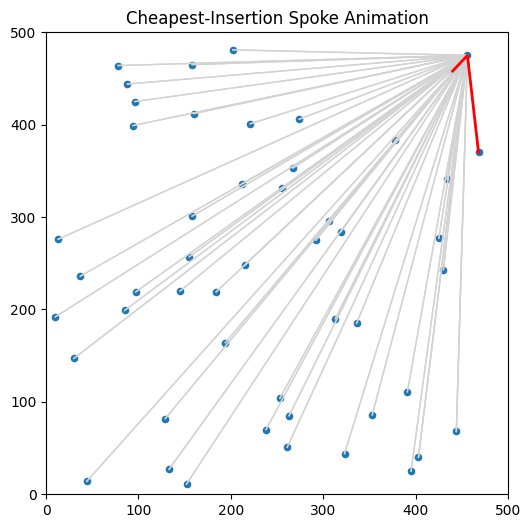

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

all_cand_segs = [] 
chosen_segs   = []

for tour_before, step_cands, best_idx in cheapest_history:
    this_step_segs = []
    for city, pos, cand, length in step_cands:
        prev_city = tour_before[pos-1] if pos>0 else tour_before[-1]
        if pos < len(tour_before):
            next_city = tour_before[pos]
        else:
            next_city = tour_before[0]

        seg = np.vstack([
            coords[prev_city],
            coords[city],
            coords[next_city]
        ])
        this_step_segs.append(seg)
    all_cand_segs.append(this_step_segs)

    city, pos, cand, length = step_cands[best_idx]
    prev_city = tour_before[pos-1] if pos>0 else tour_before[-1]
    if pos < len(tour_before):
        next_city = tour_before[pos]
    else:
        next_city = tour_before[0]
    chosen_segs.append(np.vstack([
        coords[prev_city],
        coords[city],
        coords[next_city]
    ]))

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1], s=20)
ax.set(xlim=(0,500), ylim=(0,500), aspect="equal",
       title="Cheapest‑Insertion Spoke Animation")

max_cands = max(len(s) for s in all_cand_segs)
gray_lines = [ ax.plot([],[], lw=1, color="lightgray")[0]
               for _ in range(max_cands) ]
red_line   = ax.plot([],[], lw=2, color="red")[0]

def init():
    for ln in gray_lines:
        ln.set_data([],[])
    red_line.set_data([],[])
    return gray_lines + [red_line]

def update(i):
    for ln, seg in zip(gray_lines, all_cand_segs[i]):
        ln.set_data(seg[:,0], seg[:,1])
    for ln in gray_lines[len(all_cand_segs[i]):]:
        ln.set_data([],[])
    seg = chosen_segs[i]
    red_line.set_data(seg[:,0], seg[:,1])
    return gray_lines + [red_line]

ani = animation.FuncAnimation(
    fig, update,
    frames=len(cheapest_history),
    init_func=init,
    interval=300,
    blit=True,
    repeat=False
)

HTML(ani.to_jshtml())
ani.save("cheapest_insertion_spokes.gif", writer="pillow", fps=4)
